In [21]:
"""
Marine Vessel Parameter Estimation using JAX and IPOPT
Estimates mass and damping parameters from trajectory data using optimization.
"""

import jax
# Enable float64 for better numerical accuracy
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import cyipopt
import diffrax as dfx
from scipy.io import loadmat

# ============================================================================
# VESSEL DYNAMICS FUNCTIONS
# ============================================================================

def B_matrix(a, b):
    """Thruster allocation matrix."""
    return jnp.array([
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [a/2, -a/2, b/2, -b/2]
    ])


def R_of_psi(psi):
    """Rotation matrix for heading angle."""
    c, s = jnp.cos(psi), jnp.sin(psi)
    return jnp.array([
        [c, -s, 0.],
        [s,  c, 0.],
        [0., 0., 1.]
    ])


def C_of_v(v, m11, m22, m33):
    """Coriolis-centripetal matrix."""
    u, vlat, r = v
    return jnp.array([
        [0.,       0.,     -m22*vlat],
        [0.,       0.,      m11*u],
        [m22*vlat, -m11*u,  0.]
    ])


def D_linear(Xu, Yv, Nr):
    """Linear damping matrix."""
    return jnp.diag(jnp.array([Xu, Yv, Nr]))


def rhs(t, q, lam, u_of_t, B):
    """
    Right-hand side of vessel dynamics ODE.
    q = [x, y, psi, u, v, r]: state vector
    lam = [m11, m22, m33, Xu, Yv, Nr]: parameters
    """
    m11, m22, m33, Xu, Yv, Nr = lam
    M = jnp.diag(jnp.array([m11, m22, m33]))
    
    eta = q[:3]  # Position and heading [x, y, psi]
    v = q[3:]    # Velocities [u, v, r]
    
    u_t = u_of_t(t)  # Thruster forces at time t
    R = R_of_psi(eta[2])
    C = C_of_v(v, m11, m22, m33)
    D = D_linear(Xu, Yv, Nr)
    
    eta_dot = R @ v
    v_dot = jnp.linalg.solve(M, B @ u_t - (C + D) @ v)
    
    return jnp.concatenate([eta_dot, v_dot])


# ============================================================================
# SIMULATOR FUNCTION
# ============================================================================

def make_simulator(t_meas, t_cmd, U_cmd, q0, a=0.45, b=0.9):
    """
    Create a simulator function for the vessel.
    
    Args:
        t_meas: Measurement time points
        t_cmd: Control time points  
        U_cmd: Control inputs (thruster forces)
        q0: Initial state [x, y, psi, u, v, r]
        a, b: Vessel geometry parameters
    
    Returns:
        Simulator function that maps parameters to simulated velocities
    """
    # Precompute B matrix
    B = B_matrix(a, b)
    
    # Create control interpolation (JAX-differentiable)
    u_interp = dfx.LinearInterpolation(
        ts=jnp.asarray(t_cmd), 
        ys=jnp.asarray(U_cmd)
    )
    
    # Configure ODE solver
    term = dfx.ODETerm(lambda t, y, lam: rhs(t, y, lam, u_interp.evaluate, B))
    solver = dfx.Dopri5()  # Adaptive RK solver 
    saveat = dfx.SaveAt(ts=jnp.asarray(t_meas))
    adjoint = dfx.RecursiveCheckpointAdjoint()  # Memory-efficient gradient computation
    
    @jax.jit
    def simulate(lam):
        """Simulate vessel dynamics for given parameters."""
        sol = dfx.diffeqsolve(
            term, solver,
            t0=t_meas[0], 
            t1=t_meas[-1],
            dt0=(t_meas[1] - t_meas[0]) * 0.1,  # Smaller initial step
            y0=q0, 
            args=lam,
            saveat=saveat, 
            adjoint=adjoint,
            stepsize_controller=dfx.PIDController(rtol=1e-5, atol=1e-8),
            max_steps=100_000,
        )
        return sol.ys[:, 3:6]  # Return velocities [u, v, r] only
    
    return simulate


# ============================================================================
# LOSS FUNCTION
# ============================================================================

def make_loss(simulate, U_meas, W_diag=None):
    """
    Create weighted least squares loss function.
    
    Args:
        simulate: Simulator function
        U_meas: Measured velocities [u, v, r]
        W_diag: Diagonal weights for [u, v, r]
    
    Returns:
        Loss function that maps parameters to loss value
    """
    W = jnp.asarray(W_diag) if W_diag is not None else jnp.ones(3)
    U_meas = jnp.asarray(U_meas)
    
    @jax.jit
    def loss(lam):
        """Compute weighted least squares loss."""
        U_sim = simulate(lam)
        e = U_meas - U_sim
        return jnp.sum((e**2) * W[None, :])
    
    return loss


# ============================================================================
# IPOPT INTERFACE
# ============================================================================

class JaxIpoptProblem:
    """Interface between JAX and IPOPT optimizer."""
    
    def __init__(self, loss_fun, lam_lo, lam_hi):
        self.loss_fun = loss_fun
        self.grad_fun = jax.jit(jax.grad(loss_fun))
        self.lam_lo = np.asarray(lam_lo, dtype=np.float64)
        self.lam_hi = np.asarray(lam_hi, dtype=np.float64)
        self.n = self.lam_lo.size
        
        # Validate bounds
        if np.any(self.lam_lo >= self.lam_hi):
            raise ValueError("Lower bounds must be less than upper bounds")
    
    def objective(self, x):
        # print(f"lam = {x}")
        return float(self.loss_fun(jnp.asarray(x)))
    
    def gradient(self, x):
        return np.asarray(self.grad_fun(jnp.asarray(x)), dtype=np.float64)
    
    # No constraints (only bounds)
    def constraints(self, x):
        return np.array([], dtype=np.float64)
    
    def jacobian(self, x):
        return np.array([], dtype=np.float64)
    
    def jacobianstructure(self):
        return (np.array([], dtype=int), np.array([], dtype=int))
    
    def hessianstructure(self):
        I, J = np.triu_indices(self.n)
        return I, J
    
    def hessian(self, x, lagrange, obj_factor):
        # Not used with L-BFGS approximation
        return np.zeros(self.n * (self.n + 1) // 2, dtype=np.float64)


def run_ipopt(loss_fun, lam_lo, lam_hi, lam0=None, options=None):
    """
    Run IPOPT optimization.
    
    Args:
        loss_fun: Loss function to minimize
        lam_lo: Lower bounds for parameters
        lam_hi: Upper bounds for parameters
        lam0: Initial guess (optional)
        options: Additional IPOPT options
    
    Returns:
        (optimal parameters, info dict)
    """
    prob = JaxIpoptProblem(loss_fun, lam_lo, lam_hi)
    
    nlp = cyipopt.Problem(
        n=prob.n, m=0, problem_obj=prob,
        lb=prob.lam_lo, ub=prob.lam_hi,
        cl=np.array([], dtype=np.float64), 
        cu=np.array([], dtype=np.float64)
    )
    
    # Set optimization options
    nlp.add_option('tol', 1e-6)
    nlp.add_option('acceptable_tol', 1e-6)
    nlp.add_option('max_iter', 100)
    nlp.add_option('hessian_approximation', 'limited-memory')
    nlp.add_option('print_level', 5)  # Verbosity
    nlp.add_option('mu_strategy', 'adaptive')
    
    if options:
        for key, value in options.items():
            nlp.add_option(key, value)
    
    # Set initial guess
    if lam0 is None:
        x0 = (prob.lam_lo + prob.lam_hi) / 2.0
    else:
        x0 = np.asarray(lam0, dtype=np.float64)
        # Clip to bounds for safety
        x0 = np.clip(x0, prob.lam_lo, prob.lam_hi)
    
    x_opt, info = nlp.solve(x0)
    return x_opt, info


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Load data
    print("Loading data...")
    data = loadmat('roboat_run.mat')
    thrusters = jnp.array(data['thrusters'])    # shape (249, 4)
    time = jnp.array(data['time'].ravel())      # shape (249,)
    trajectory = jnp.array(data['trajectory'])  # shape (249, 6)
    
    # Known vessel geometry
    a = 0.45  # transverse separation (m)
    b = 0.9   # longitudinal separation (m)
    
    # Extract data for optimization
    t_meas = time
    U_meas = trajectory[:, 3:6]  # Measured velocities [u, v, r]
    t_cmd = time
    U_cmd = thrusters
    q0 = trajectory[0]  # Initial state
    
    # Create simulator and loss function
    print("Setting up simulator and loss function...")
    simulate = make_simulator(t_meas, t_cmd, U_cmd, q0, a, b)
    loss_fun = make_loss(simulate, U_meas, W_diag=jnp.array([1., 1., 1.]))
    
    # Define parameter bounds [m11, m22, m33, Xu, Yv, Nr]
    lam_lo = jnp.array([1.,  1.,  0.01, 0.1, 0.1, 0.01])
    lam_hi = jnp.array([60., 60., 10.,  20., 20., 5.])
    
    # Initial guess
    lam0 = jnp.array([8., 8., 2., 3., 8., 1.])
    # lam0 = jnp.array([29, 44., 2.42, 10.2, 9.2, 1.02])
    
    # Run optimization
    print("Starting optimization...")
    print(f"Initial loss: {float(loss_fun(lam0)):.6f}")
    
    lam_hat, info = run_ipopt(loss_fun, lam_lo, lam_hi, lam0=lam0)
    
    # Display results
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Estimated parameters:")
    param_names = ['m11', 'm22', 'm33', 'Xu', 'Yv', 'Nr']
    for name, val in zip(param_names, lam_hat):
        print(f"  {name:3s} = {val:8.4f}")
    print(f"\nInitial loss: {float(loss_fun(lam0)):.6f}")
    print(f"Final loss:   {float(loss_fun(jnp.asarray(lam_hat))):.6f}")
    print(f"Reduction:    {(1 - float(loss_fun(jnp.asarray(lam_hat)))/float(loss_fun(lam0)))*100:.2f}%")
    print(f"\nOptimization status: {info['status_msg']}")
    # print(f"Number of iterations: {info['iter_count']}")

Loading data...
Setting up simulator and loss function...
Starting optimization...
Initial loss: 5.401322
This is Ipopt version 3.14.19, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  


TRAJECTORY COMPARISON
RMS Errors:
  Position:  x=0.3634 m,  y=0.5933 m
  Heading:   ψ=24.8647 deg
  Velocity:  u=0.0518 m/s,  v=0.0311 m/s,  r=7.2650 deg/s

Max Absolute Errors:
  Position:  x=0.6952 m,  y=1.2776 m
  Heading:   ψ=42.1780 deg
  Velocity:  u=0.1369 m/s,  v=0.0717 m/s,  r=15.6680 deg/s

R-squared values (velocities):
  u: 0.6703
  v: 0.5826
  r: 0.8488

Generating comparison plots...


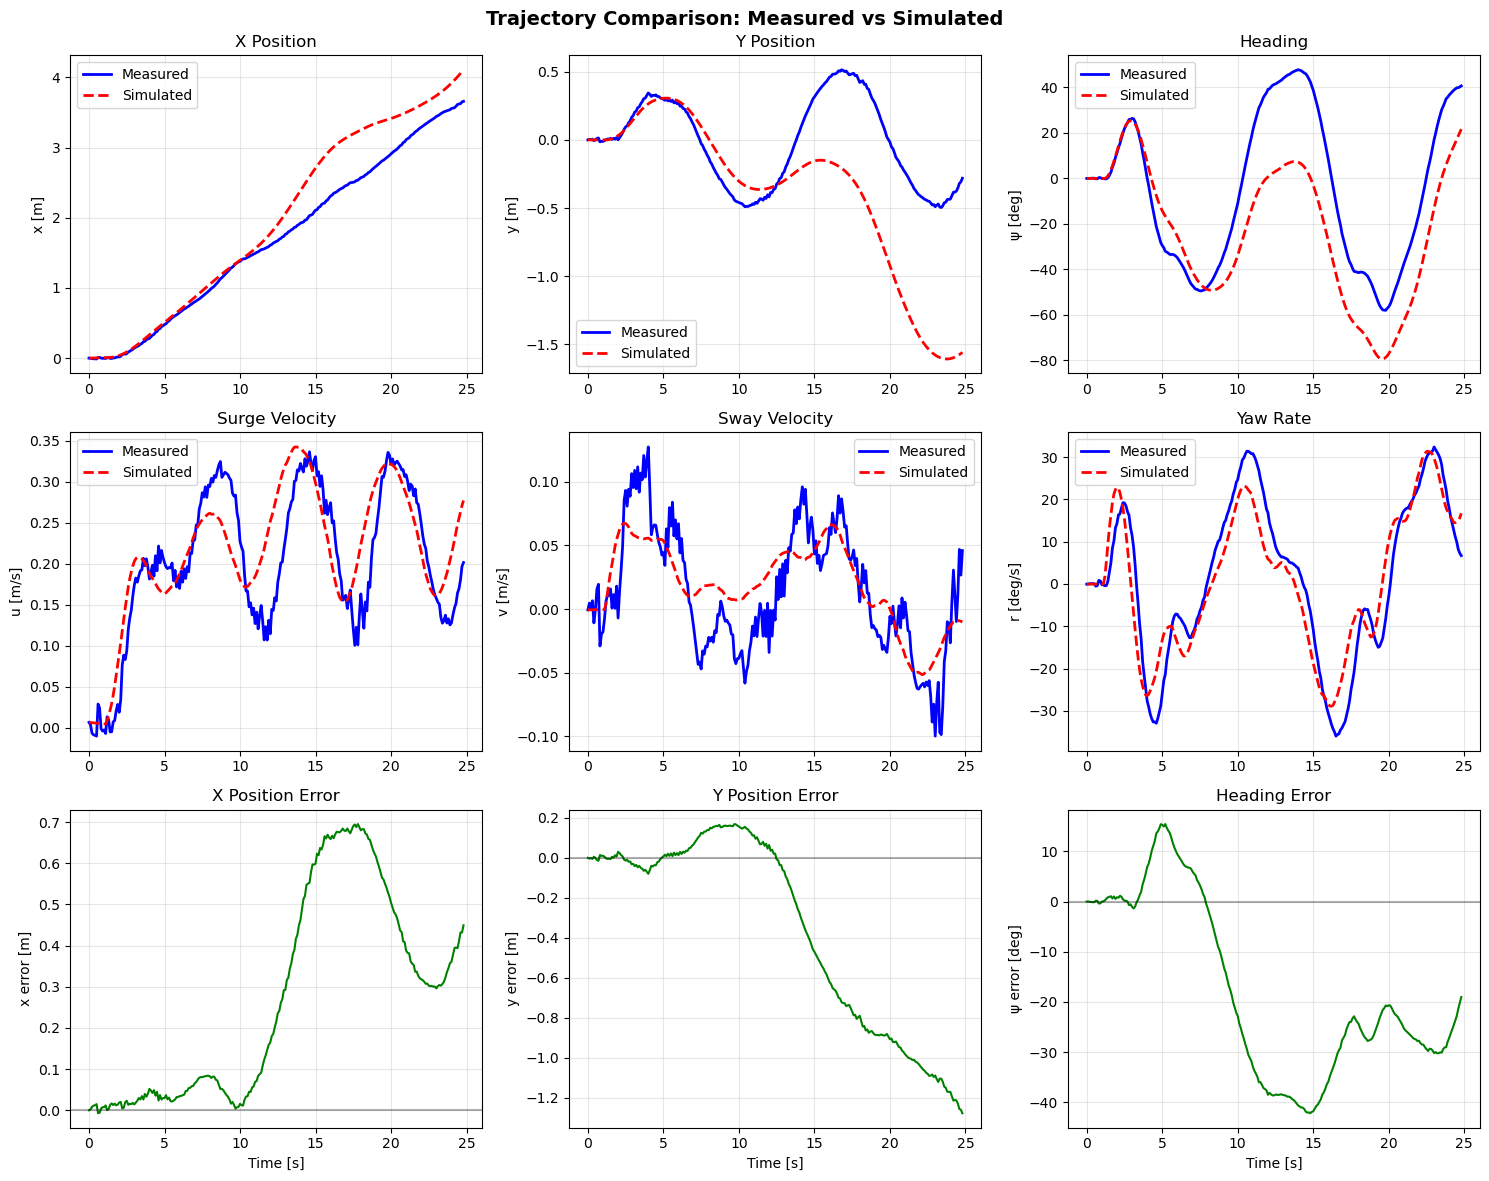

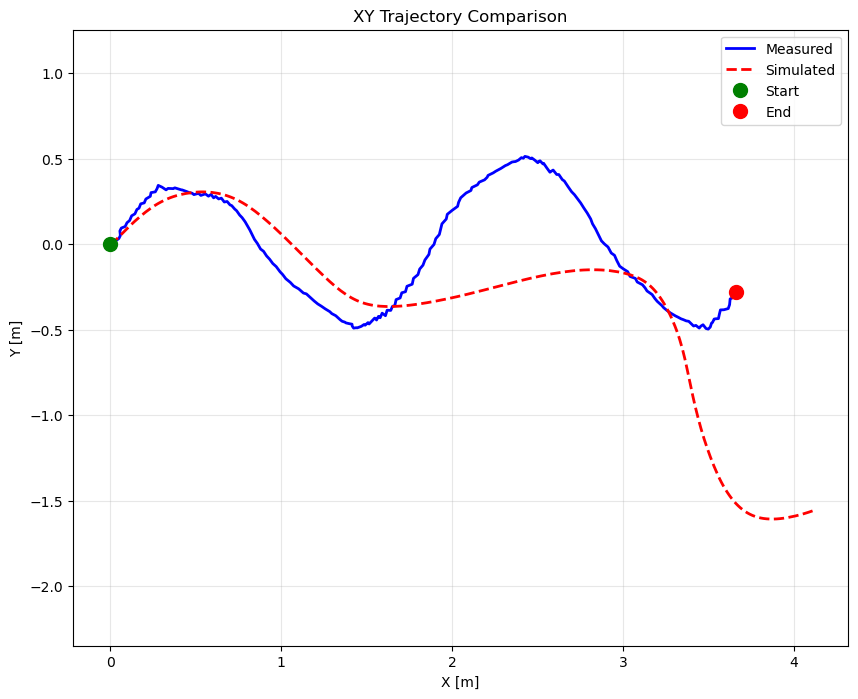

Plots saved as 'trajectory_comparison.png' and 'xy_trajectory.png'

[Results stored in 'results' dictionary for further analysis]


In [20]:

print("\n" + "="*60)
print("TRAJECTORY COMPARISON")
print("="*60)

# Create a full trajectory simulator (returns all states, not just velocities)
def make_full_simulator(t_meas, t_cmd, U_cmd, q0, a=0.45, b=0.9):
    """Create simulator that returns full state trajectory."""
    B = B_matrix(a, b)
    u_interp = dfx.LinearInterpolation(
        ts=jnp.asarray(t_cmd), 
        ys=jnp.asarray(U_cmd)
    )
    
    term = dfx.ODETerm(lambda t, y, lam: rhs(t, y, lam, u_interp.evaluate, B))
    solver = dfx.Dopri5()
    saveat = dfx.SaveAt(ts=jnp.asarray(t_meas))
    adjoint = dfx.RecursiveCheckpointAdjoint()
    
    @jax.jit
    def simulate_full(lam):
        sol = dfx.diffeqsolve(
            term, solver,
            t0=t_meas[0], 
            t1=t_meas[-1],
            dt0=(t_meas[1] - t_meas[0]) * 0.1,
            y0=q0, 
            args=lam,
            saveat=saveat, 
            adjoint=adjoint,
            stepsize_controller=dfx.PIDController(rtol=1e-5, atol=1e-8),
            max_steps=100_000,
        )
        return sol.ys  # Return full state [x, y, psi, u, v, r]
    
    return simulate_full

# Simulate with estimated parameters
simulate_full = make_full_simulator(t_meas, t_cmd, U_cmd, q0, a, b)
trajectory_sim = simulate_full(lam_hat)

# Convert to numpy for analysis
trajectory_sim_np = np.array(trajectory_sim)
trajectory_meas_np = np.array(trajectory)

# Compute errors
position_error = trajectory_sim_np[:, :2] - trajectory_meas_np[:, :2]  # x, y errors
heading_error = trajectory_sim_np[:, 2] - trajectory_meas_np[:, 2]     # psi error
velocity_error = trajectory_sim_np[:, 3:6] - trajectory_meas_np[:, 3:6]  # u, v, r errors

# Wrap heading error to [-pi, pi]
heading_error = np.arctan2(np.sin(heading_error), np.cos(heading_error))

# Compute RMS errors
rms_x = np.sqrt(np.mean(position_error[:, 0]**2))
rms_y = np.sqrt(np.mean(position_error[:, 1]**2))
rms_psi = np.sqrt(np.mean(heading_error**2))
rms_u = np.sqrt(np.mean(velocity_error[:, 0]**2))
rms_v = np.sqrt(np.mean(velocity_error[:, 1]**2))
rms_r = np.sqrt(np.mean(velocity_error[:, 2]**2))

print("RMS Errors:")
print(f"  Position:  x={rms_x:.4f} m,  y={rms_y:.4f} m")
print(f"  Heading:   ψ={np.degrees(rms_psi):.4f} deg")
print(f"  Velocity:  u={rms_u:.4f} m/s,  v={rms_v:.4f} m/s,  r={np.degrees(rms_r):.4f} deg/s")

# Compute max errors
max_x = np.max(np.abs(position_error[:, 0]))
max_y = np.max(np.abs(position_error[:, 1]))
max_psi = np.max(np.abs(heading_error))
max_u = np.max(np.abs(velocity_error[:, 0]))
max_v = np.max(np.abs(velocity_error[:, 1]))
max_r = np.max(np.abs(velocity_error[:, 2]))

print("\nMax Absolute Errors:")
print(f"  Position:  x={max_x:.4f} m,  y={max_y:.4f} m")
print(f"  Heading:   ψ={np.degrees(max_psi):.4f} deg")
print(f"  Velocity:  u={max_u:.4f} m/s,  v={max_v:.4f} m/s,  r={np.degrees(max_r):.4f} deg/s")

# Compute R-squared for velocities (what we're fitting)
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

r2_u = r_squared(trajectory_meas_np[:, 3], trajectory_sim_np[:, 3])
r2_v = r_squared(trajectory_meas_np[:, 4], trajectory_sim_np[:, 4])
r2_r = r_squared(trajectory_meas_np[:, 5], trajectory_sim_np[:, 5])

print(f"\nR-squared values (velocities):")
print(f"  u: {r2_u:.4f}")
print(f"  v: {r2_v:.4f}")
print(f"  r: {r2_r:.4f}")

# ========================================================================
# PLOTTING (if matplotlib is available)
# ========================================================================

try:
    import matplotlib.pyplot as plt
    
    print("\nGenerating comparison plots...")
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # Position plots
    axes[0, 0].plot(time, trajectory_meas_np[:, 0], 'b-', label='Measured', linewidth=2)
    axes[0, 0].plot(time, trajectory_sim_np[:, 0], 'r--', label='Simulated', linewidth=2)
    axes[0, 0].set_ylabel('x [m]')
    axes[0, 0].set_title('X Position')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(time, trajectory_meas_np[:, 1], 'b-', label='Measured', linewidth=2)
    axes[0, 1].plot(time, trajectory_sim_np[:, 1], 'r--', label='Simulated', linewidth=2)
    axes[0, 1].set_ylabel('y [m]')
    axes[0, 1].set_title('Y Position')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[0, 2].plot(time, np.degrees(trajectory_meas_np[:, 2]), 'b-', label='Measured', linewidth=2)
    axes[0, 2].plot(time, np.degrees(trajectory_sim_np[:, 2]), 'r--', label='Simulated', linewidth=2)
    axes[0, 2].set_ylabel('ψ [deg]')
    axes[0, 2].set_title('Heading')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Velocity plots
    axes[1, 0].plot(time, trajectory_meas_np[:, 3], 'b-', label='Measured', linewidth=2)
    axes[1, 0].plot(time, trajectory_sim_np[:, 3], 'r--', label='Simulated', linewidth=2)
    axes[1, 0].set_ylabel('u [m/s]')
    axes[1, 0].set_title('Surge Velocity')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(time, trajectory_meas_np[:, 4], 'b-', label='Measured', linewidth=2)
    axes[1, 1].plot(time, trajectory_sim_np[:, 4], 'r--', label='Simulated', linewidth=2)
    axes[1, 1].set_ylabel('v [m/s]')
    axes[1, 1].set_title('Sway Velocity')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].plot(time, np.degrees(trajectory_meas_np[:, 5]), 'b-', label='Measured', linewidth=2)
    axes[1, 2].plot(time, np.degrees(trajectory_sim_np[:, 5]), 'r--', label='Simulated', linewidth=2)
    axes[1, 2].set_ylabel('r [deg/s]')
    axes[1, 2].set_title('Yaw Rate')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Error plots
    axes[2, 0].plot(time, position_error[:, 0], 'g-', linewidth=1.5)
    axes[2, 0].set_ylabel('x error [m]')
    axes[2, 0].set_xlabel('Time [s]')
    axes[2, 0].set_title('X Position Error')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    axes[2, 1].plot(time, position_error[:, 1], 'g-', linewidth=1.5)
    axes[2, 1].set_ylabel('y error [m]')
    axes[2, 1].set_xlabel('Time [s]')
    axes[2, 1].set_title('Y Position Error')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    axes[2, 2].plot(time, np.degrees(heading_error), 'g-', linewidth=1.5)
    axes[2, 2].set_ylabel('ψ error [deg]')
    axes[2, 2].set_xlabel('Time [s]')
    axes[2, 2].set_title('Heading Error')
    axes[2, 2].grid(True, alpha=0.3)
    axes[2, 2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    plt.suptitle('Trajectory Comparison: Measured vs Simulated', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('trajectory_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # XY trajectory plot
    fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.plot(trajectory_meas_np[:, 0], trajectory_meas_np[:, 1], 'b-', label='Measured', linewidth=2)
    ax.plot(trajectory_sim_np[:, 0], trajectory_sim_np[:, 1], 'r--', label='Simulated', linewidth=2)
    ax.plot(trajectory_meas_np[0, 0], trajectory_meas_np[0, 1], 'go', markersize=10, label='Start')
    ax.plot(trajectory_meas_np[-1, 0], trajectory_meas_np[-1, 1], 'ro', markersize=10, label='End')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title('XY Trajectory Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    plt.savefig('xy_trajectory.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Plots saved as 'trajectory_comparison.png' and 'xy_trajectory.png'")
    
except ImportError:
    print("\n[Note: Install matplotlib to see comparison plots]")

# Return results for further analysis
results = {
    'lam_hat': lam_hat,
    'trajectory_sim': trajectory_sim_np,
    'trajectory_meas': trajectory_meas_np,
    'rms_errors': {'x': rms_x, 'y': rms_y, 'psi': rms_psi, 
                    'u': rms_u, 'v': rms_v, 'r': rms_r},
    'r_squared': {'u': r2_u, 'v': r2_v, 'r': r2_r}
}

print("\n[Results stored in 'results' dictionary for further analysis]")